In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


In [3]:
# Ön işleme fonksiyonlarını tanımlayın
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

def stem_words(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

# nltk paketlerini indirin
nltk.download('stopwords')
nltk.download('wordnet')

# Veri yolu
data_path = "dataset/*.html"
code2convos = dict()
pbar = tqdm.tqdm(sorted(list(glob(data_path))))

for path in pbar:
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")

        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []
        for convo in conversations:
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile(r"[user|assistant]")})
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                text = convo[0].text
                # Ön işleme adımlarını uygulayın
                text = clean_text(text)
                text = remove_stopwords(text)
                text = stem_words(text)
                convo_texts.append({
                    "role": role,
                    "text": text
                })

        code2convos[file_code] = convo_texts

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aydint/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/aydint/nltk_data...
100%|██████████| 127/127 [00:10<00:00, 12.24it/s]


In [4]:
data_path = "dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:04<00:00, 25.61it/s]


In [5]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [6]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [7]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [65]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset 
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing 
Understanding the Dataset: 
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: 

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data 

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations 

* Correlations of features with health 
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection 
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features 
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters 
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. 
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* 
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen 
- Re-train model with the hyperparameters you have chosen in part 5). 
- Plot the tree you have trained. 
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set 
- Predict the labels of testing data using the tree you have trained in step 6. 
- Report the classification accuracy. 
- Plot & investigate the confusion matrix. Fill the following blanks. 
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split """,
#####################
]


for i in range(len(questions)):
    # Satır başları ve sonlarındaki boşlukları kaldır
    questions[i] = questions[i].strip()
    
    # Birden fazla boşlukları tek boşlukla değiştir
    questions[i] = re.sub(' +', ' ', questions[i])
    
    # Satır sonu karakterlerini kaldır
    questions[i] = questions[i].replace('\n', ' ')
    
    # Özel karakterleri kaldır (eğer varsa)
    questions[i] = re.sub(r'[^\x00-\x7F]+', '', questions[i])




Initialize * First make a copy of the notebook given to you as a starter. * Make sure you choose Connect form upper right. * You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.


In [10]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [47]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
##Drop the columns with zero
questions_TF_IDF = questions_TF_IDF.loc[:, (questions_TF_IDF != 0).any(axis=0)]
questions_TF_IDF.head()

,10,15,20,80,__,_________,__note,accuracy,all,and,...,value,values,variable,what,when,why,will,with,you,your
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.00000,0.000000,0.054079,...,0.0,0.000000,0.000000,0.0,0.115711,0.0,0.09933,0.000000,0.210376,0.075430
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.00000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.162418,0.000000,0.000000
2,0.053153,0.067182,0.000000,0.000000,0.00000,0.0,0.00000,0.00000,0.000000,0.040375,...,0.0,0.156026,0.052348,0.0,0.000000,0.0,0.00000,0.074266,0.235600,0.000000
3,0.000000,0.000000,0.159726,0.186978,0.00000,0.0,0.00000,0.00000,0.000000,0.314141,...,0.0,0.000000,0.271530,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.292113
4,0.064021,0.000000,0.000000,0.000000,0.15363,0.0,0.15363,0.06531,0.074597,0.097261,...,0.0,0.000000,0.126103,0.0,0.000000,0.0,0.00000,0.134178,0.047296,0.135662


In [12]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [67]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

for code, df in code2prompts_tf_idf.items():
    # Tüm değerleri sıfır olan sütunları bul
    zero_columns = df.columns[(df == 0).all(axis=0)]
    
    # Bu sütunları kaldır
    df.drop(zero_columns, axis=1, inplace=True)
    
    # Güncellenmiş DataFrame'i sözlüğe geri kaydet
    code2prompts_tf_idf[code] = df



In [52]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 701)

In [15]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [16]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [55]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [18]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [20]:
from textblob import TextBlob  # Duyarlılık analizi için

for code, convs in code2convos.items():
    if len(convs) == 0:
        continue

    total_user_prompts = 0
    total_responses = 0
    total_user_sentiment = 0
    total_response_sentiment = 0

    for c in convs:
        text = c["text"].lower()
        sentiment = TextBlob(text).sentiment.polarity  # Metnin duyarlılık puanını hesapla

        if c["role"] == "user":
            # User Prompts
            total_user_prompts += 1
            total_user_sentiment += sentiment
            # ... (mevcut kullanıcı girdisi işlemleri)
        else:
            # ChatGPT Responses
            total_responses += 1
            total_response_sentiment += sentiment
            # ... (mevcut ChatGPT yanıtı işlemleri)

    # Ortalama duyarlılık puanlarını hesapla
    code2features[code]["avg_user_sentiment"] = total_user_sentiment / total_user_prompts if total_user_prompts > 0 else 0
    code2features[code]["avg_response_sentiment"] = total_response_sentiment / total_responses if total_responses > 0 else 0

    # ... (mevcut hesaplamalar)


In [21]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,avg_response_sentiment
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.139457,0.077251
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.130718,0.178345
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,-0.021337,0.194257
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.004042,0.141033
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.089507,0.150860


In [56]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


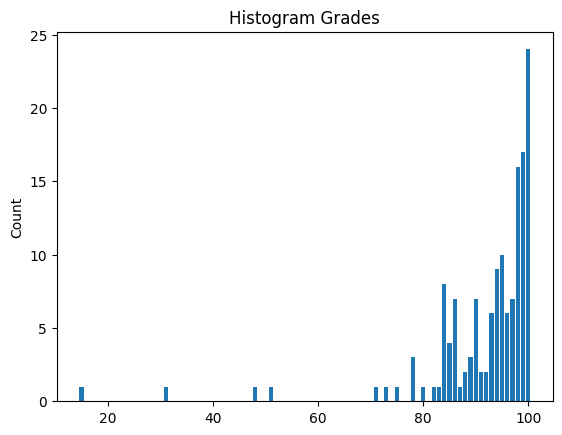

In [23]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [24]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,avg_response_sentiment
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.139457,0.077251
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.130718,0.178345
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,-0.021337,0.194257
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.004042,0.141033
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.089507,0.150860


In [25]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,avg_response_sentiment,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.139457,0.077251,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.130718,0.178345,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,-0.021337,0.194257,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.004042,0.141033,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.089507,0.150860,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


#### Merging scores with features

In [26]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.139457,...,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.130718,...,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,-0.021337,...,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.004042,...,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.089507,...,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


In [27]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 19) (122,)


#### Train/Test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [57]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [58]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 0.0
Node 2 has MSE 126.39409722222263
Node 3 has MSE 64.35004526935154
Node 4 has MSE 167.02777777777737
Node 5 has MSE 83.96484375
Node 6 has MSE 51.6875
Node 7 has MSE 0.0
Node 8 has MSE 10.489795918369055
Node 9 has MSE 0.6666666666660603
Node 10 has MSE 0.0
Node 11 has MSE 0.25
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 0.0
Node 15 has MSE 54.359375
Node 16 has MSE 1.0
Node 17 has MSE 0.0
Node 18 has MSE 0.0
Node 19 has MSE 26.58333333333303
Node 20 has MSE 12.6875
Node 21 has MSE 0.0
Node 22 has MSE 4.66666666666697
Node 23 has MSE 0.25
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 0.0
Node 27 has MSE 9.0
Node 28 has MSE 0.0
Node 29 has MSE 0.0
Node 30 has MSE 100.0
Node 31 has MSE 0.0
Node 32 has MSE 0.0
Node 33 has MSE 27.533240997230678
Node 34 has MSE 25.170927684439448
Node 35 has MSE 22.85062487601499
Node 36 has MSE 6.888888888887777
Node 37 has MSE 0.0
Node 38 has MSE 0.25
Node 39 has MSE 0.0
Node 40 h

In [31]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [32]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 8.279086892488953
MSE TEST: 104.95122448979592
R2 Train: 0.9493387005574656
R2 TEST: 0.06515241988823006


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.svm import SVR

In [59]:
# RandomForest için parametre aralığı
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# XGBoost için parametre aralığı
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# SVR için parametre aralığı
svr_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Modelin oluşturulması ve eğitimi
# RandomForest
rf_regressor = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5)
rf_regressor.fit(X_train, y_train)

# XGBoost
xgb_regressor = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_params, cv=5)
xgb_regressor.fit(X_train, y_train)

# SVR
svr_regressor = GridSearchCV(SVR(), svr_params, cv=5)
svr_regressor.fit(X_train, y_train)

# En iyi parametreler ve skorları yazdır
print("En iyi RandomForest parametreleri:", rf_regressor.best_params_)
print("En iyi RandomForest skoru:", rf_regressor.best_score_)
print("En iyi XGBoost parametreleri:", xgb_regressor.best_params_)
print("En iyi XGBoost skoru:", xgb_regressor.best_score_)
print("En iyi SVR parametreleri:", svr_regressor.best_params_)
print("En iyi SVR skoru:", svr_regressor.best_score_)

# Test seti üzerinde final değerlendirme
y_pred_rf = rf_regressor.predict(X_test)
y_pred_xgb = xgb_regressor.predict(X_test)
y_pred_svr = svr_regressor.predict(X_test)

print("RandomForest MSE:", mean_squared_error(y_test, y_pred_rf))
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))
print("SVR MSE:", mean_squared_error(y_test, y_pred_svr))

En iyi RandomForest parametreleri: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
En iyi RandomForest skoru: -0.7198222706899212
En iyi XGBoost parametreleri: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
En iyi XGBoost skoru: -1.1129596799021049
En iyi SVR parametreleri: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
En iyi SVR skoru: -0.09704373166625171
RandomForest MSE: 108.98449113085584
XGBoost MSE: 108.49032808580901
SVR MSE: 121.02250534399545


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Tahminler')

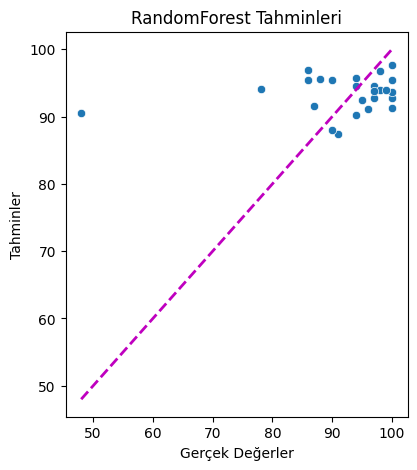

In [36]:
# Gerçek değerler ve tahminlerin yan yana gösterilmesi
plt.figure(figsize=(15, 5))

# RandomForest tahminleri
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=2)
plt.title('RandomForest Tahminleri')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')

Text(0, 0.5, 'Tahminler')

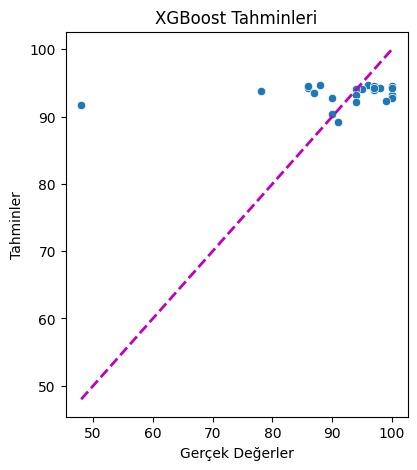

In [37]:
plt.figure(figsize=(15, 5))
# XGBoost tahminleri
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=2)
plt.title('XGBoost Tahminleri')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')

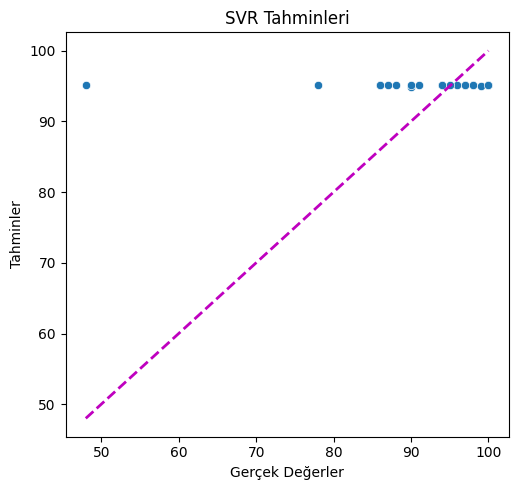

In [38]:
plt.figure(figsize=(15, 5))
# SVR tahminleri
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_svr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=2)
plt.title('SVR Tahminleri')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')

plt.tight_layout()
plt.show()

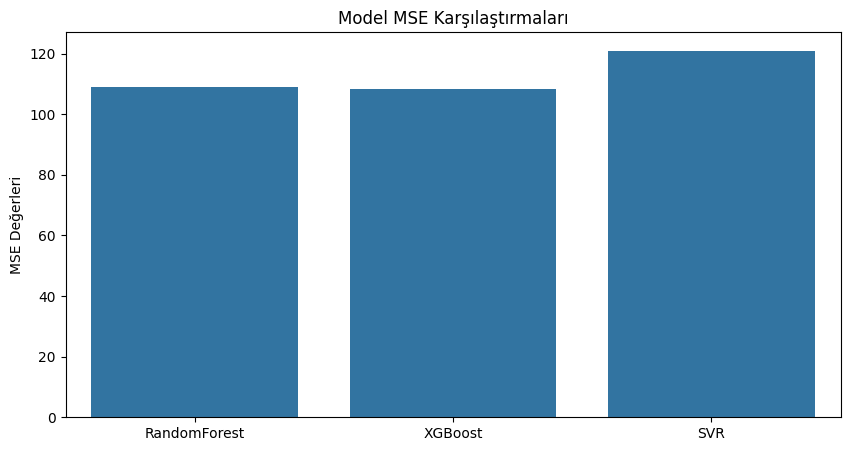

In [39]:
# Model performanslarını bar grafik olarak gösterme
models = ['RandomForest', 'XGBoost', 'SVR']
mses = [mean_squared_error(y_test, y_pred_rf), mean_squared_error(y_test, y_pred_xgb), mean_squared_error(y_test, y_pred_svr)]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=mses)
plt.title('Model MSE Karşılaştırmaları')
plt.ylabel('MSE Değerleri')
plt.show()